# Sprint　アンサンブル学習  

＜目的＞  
- アンサンブル学習について理解する  

3種類のアンサンブル学習をスクラッチ実装していきます。そして、それぞれの効果を小さめのデータセットで確認します。  
- ブレンディング
- バギング
- スタッキング

＜小さなデータセットの用意＞  
以前も利用した回帰のデータセットを用意します。  

House Prices: Advanced Regression Techniques  

この中の``train.csv``をダウンロードし、目的変数として``SalePrice``、説明変数として、``GrLivArea``と``YearBuilt``を使います。  

train.csvを学習用（train）8割、検証用（val）2割に分割してください。

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import copy

In [29]:
# データの読み込み
data = pd.read_csv('train.csv')
df_house = data[['GrLivArea', 'YearBuilt', 'SalePrice']]
print('< House Price >')
display(df_house.head())
print('size :', np.shape(df_house))

< House Price >


,GrLivArea,YearBuilt,SalePrice
0,1710,2003,208500
1,1262,1976,181500
2,1786,2001,223500
3,1717,1915,140000
4,2198,2000,250000


size : (1460, 3)


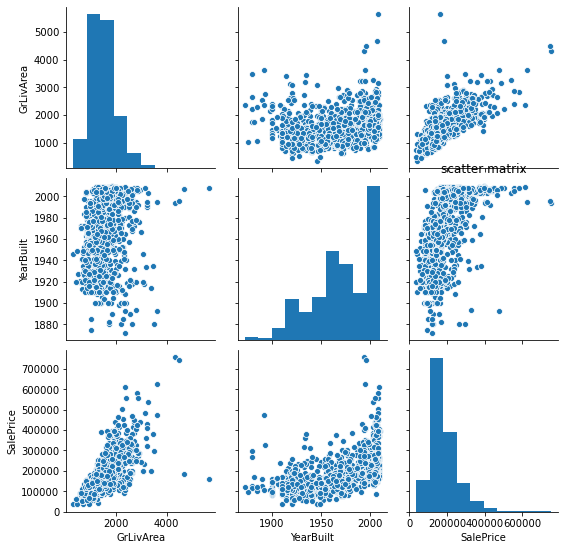

In [30]:
# 散布図行列
sns.pairplot(df_house)
plt.title('scatter matrix')
plt.show()

- 目的変数である住宅価格は右に裾の長い分布をしており、対数化しても良さそうだ
- 標準化と対数化の両方を試す

In [31]:
# データ取得
X = df_house.iloc[:, :-1].values
y = df_house.iloc[:, -1].values

# 分割
X_train, X_val, y_train, y_val = train_test_split(
    X, y, random_state=0, train_size=0.8)

# 回帰のため、目的変数も標準化
sc_x = StandardScaler()
sc_y = StandardScaler()
sc_x.fit(X_train)
sc_y.fit(y_train[:, np.newaxis])
X_train_std = sc_x.transform(X_train)
X_val_std = sc_x.transform(X_val)
y_train_std = sc_y.transform(y_train[:, np.newaxis]).flatten()
y_val_std = sc_y.transform(y_val[:, np.newaxis]).flatten()

In [32]:
# 回帰問題可視化関数
def regression_visualize(X, y, model_name='model', models=[], titles=[], colors=[], xlabels=[], ylabel='y'):
    print("< {} >".format(model_name))
    n_var = np.shape(X)[1]
    fig,ax = plt.subplots(nrows=1,ncols=n_var,figsize=(10,2*n_var))
    plt.subplots_adjust(wspace=0.6, hspace=0.2)
    for i in range(n_var):
        x = X[:, i][:, np.newaxis]
        sort_indx = x.flatten().argsort()
        y_pred = models[i].predict(x).flatten()
        plt.subplot(1,n_var,i+1)
        plt.scatter(x, y, color=colors[i], edgecolor='white')
        plt.plot(x[sort_indx], y_pred[sort_indx], color='black')
        plt.title("{}".format(titles[i]))
        plt.xlabel('{}'.format(xlabels[i]))
        plt.ylabel('{}'.format(ylabel))   
    plt.show()

### 【問題1】ブレンディングのスクラッチ実装  
ブレンディング をスクラッチ実装し、単一モデルより精度があがる例を 最低3つ 示してください。精度があがるとは、検証用データに対する平均二乗誤差（MSE）が小さくなることを指します。  

＜ブレンディングとは＞  
ブレンディングとは、N個の多様なモデルを独立して学習させ、推定結果を重み付けした上で足し合わせる方法です。最も単純には平均をとります。多様なモデルとは、以下のような条件を変化させることで作り出すものです。  

- 手法（例：線形回帰、SVM、決定木、ニューラルネットワークなど）
- ハイパーパラメータ（例：SVMのカーネルの種類、重みの初期値など）
- 入力データの前処理の仕方（例：標準化、対数変換、PCAなど）

重要なのはそれぞれのモデルが大きく異なることです。  
回帰問題でのブレンディングは非常に単純であるため、scikit-learnには用意されていません。


### ＜方針＞  
1.手法、2.ハーパーパラメーター、3.前処理　の観点から単体モデルとブレンドモデルの比較を行う。

In [33]:
# Blending Classの実装
class Blending_Regression():
    """
    回帰問題ブレンディングのスクラッチ実装

    Parameters
    ----------
    models : list
      ブレンドするモデルのオブジェクトリスト
    W : 次の形のndarray, shape (n_models,)
    　各モデルに対する重みの配列

    Attributes
    ----------
    self.scores_ : 次の形のndarray, shape (n_features,)
      各モデルのスコア
    """
    def __init__(self, models, W):
        # ハイパーパラメータを属性として記録
        self.models = models
        self.W = W
        
    def fit(self, X, y):
        """
   　　 受け取ったデータで学習を行う

    　　Parameters
    　　----------
    　　X : 次の形のndarray, shape (n_samples, n_features)
      　　訓練データの説明変数
 　　　 y : 次の形のndarray, shape (n_samples, )
      　　訓練データの目的変数
      　"""
        # 受け取った各モデルで学習
        for i in range(len(self.models)):
            self.models[i].fit(X, y)
        return self
    
    def predict(self, X):
        """
        受け取ったデータで推定を行う

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          予測するデータの説明変数
        Returns
        -------
        y_pred : 次の形のndarray, shape (n_samples, 1)
          各モデル推定のブレンド結果
        """
        # 各モデルによる推定行列を初期値0で作成
        predicts = np.zeros([X.shape[0], len(self.models)])
        # 各モデルで推定し、推定行列の該当列を更新
        for i in range(len(self.models)):
            predicts[:, i] = self.models[i].predict(X)
        
        # 重み配列をかけて出力
        return predicts@self.W[:, np.newaxis]

In [34]:
# 回帰問題の学習・予測・可視化・評価を関数化
def execute_regression(names, models, X_train, y_train, X_val, y_val):
    
    # 可視化のため変数毎に分割
    X1_train = X_train[:, 0][:, np.newaxis]
    X2_train = X_train[:, 1][:, np.newaxis]
    
    for i in range(models.shape[1]):
        print("\n=== {} ===\n".format(names[i]))

        # 可視化のため変数毎に学習
        models[1, i].fit(X1_train, y_train)
        models[2, i].fit(X2_train, y_train)

        # 訓練データで可視化
        regression_visualize(X_train, y_train, 
                             model_name='train data', 
                             models=[models[1, i], models[2, i]], 
                             titles=['SalesPrice / GrLivArea (train)', 'SalesPrice / YearBuilt (train)'],
                             colors=['steelblue', 'orange'],
                             xlabels=['Living Area [$feet^2$] (standardized)', 'Original construction date [$year$] (standardized)'],
                             ylabel='Price [$] (standardized)')
        
        # 検証データで可視化
        regression_visualize(X_val, y_val, 
                             model_name='validation data', 
                             models=[models[1, i], models[2, i]], 
                             titles=['SalesPrice / GrLivArea (validation)', 'SalesPrice / YearBuilt (validation)'],
                             colors=['steelblue', 'orange'],
                             xlabels=['Living Area [$feet^2$] (standardized)', 'Original construction date [$year$] (standardized)'],
                             ylabel='Price [$] (standardized)')
        
        # 評価(平均二乗誤差、決定係数)
        print("< Metrics (validation data) >")
        models[0, i].fit(X_train, y_train)
        y_val_pred = models[0, i].predict(X_val)
        MSE = mean_squared_error(y_val, y_val_pred)
        print('MSE : {:.3f}'.format(MSE))
        R2 = r2_score(y_val, y_val_pred)
        print('R^2 : {:.3f}'.format(R2))

### 1. 手法  
データは目的・説明変数ともに標準化し、外れ値を除去したものを使用。  
ハーパーパラメータは調整せずdefaultで学習・推定。


=== LinearRegression ===

< train data >


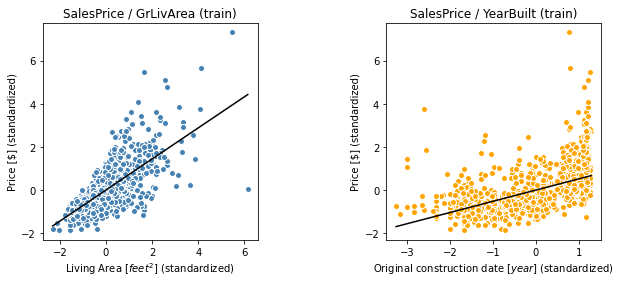

< validation data >


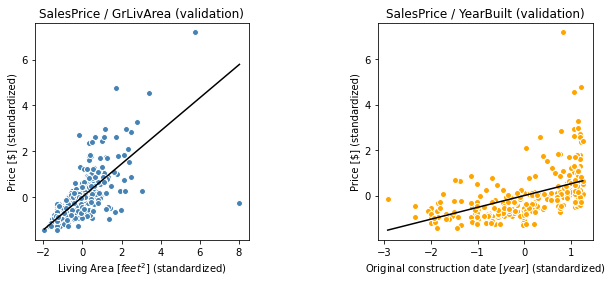

< Metrics (validation data) >
MSE : 0.478
R^2 : 0.574

=== Support Vector Regression ===

< train data >


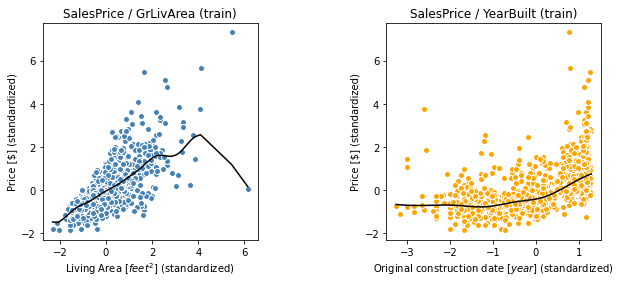

< validation data >


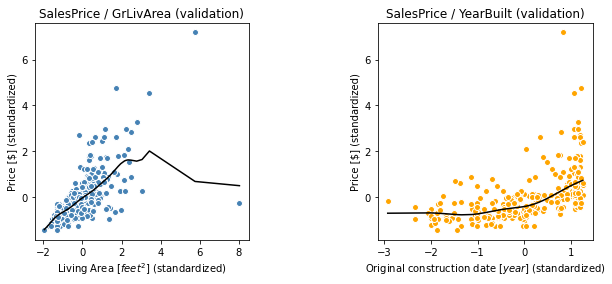

< Metrics (validation data) >
MSE : 0.389
R^2 : 0.653

=== Decision Tree Regression ===

< train data >


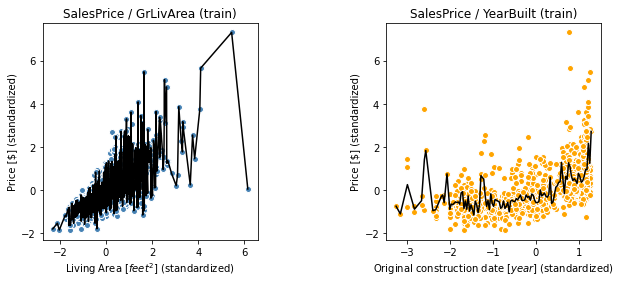

< validation data >


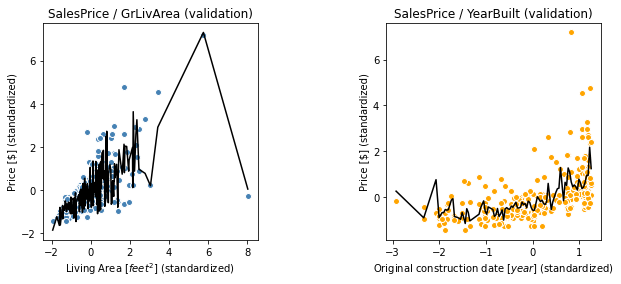

< Metrics (validation data) >
MSE : 0.528
R^2 : 0.529


In [35]:
# 線形回帰
lr = LinearRegression()
lr_1 = copy.deepcopy(lr)
lr_2 = copy.deepcopy(lr)

# SVM
svm = SVR()
svm_1 = copy.deepcopy(svm)
svm_2 = copy.deepcopy(svm)

# 決定木
tree = DecisionTreeRegressor()
tree_1 = copy.deepcopy(tree)
tree_2 = copy.deepcopy(tree)

# 各モデル単体で実行
names = ['LinearRegression', 'Support Vector Regression', 'Decision Tree Regression']
models = np.array([[lr, svm, tree], [lr_1, svm_1, tree_1], [lr_2, svm_2, tree_2]])
execute_regression(names=names, 
                   models=models, 
                   X_train=X_train_std, y_train=y_train_std, 
                   X_val=X_val_std, y_val=y_val_std)

In [36]:
# 外れ値と思われるサンプルを削除
X_train_del = np.delete(X_train_std, np.where(X_train_std[:, 0]>6)[0], axis=0)
y_train_del = np.delete(y_train_std, np.where(X_train_std[:, 0]>6)[0], axis=0)
X_val_del = np.delete(X_val_std, np.where(X_val_std[:, 0]>7)[0], axis=0)
y_val_del = np.delete(y_val_std, np.where(X_val_std[:, 0]>7)[0], axis=0)


=== LinearRegression ===

< train data >


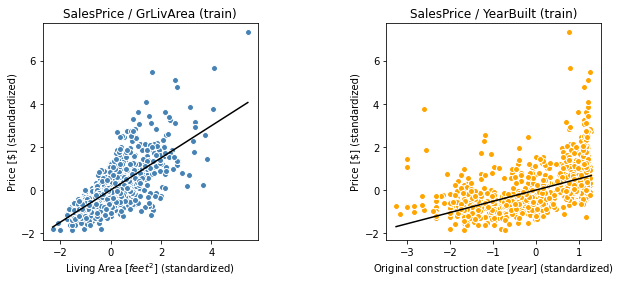

< validation data >


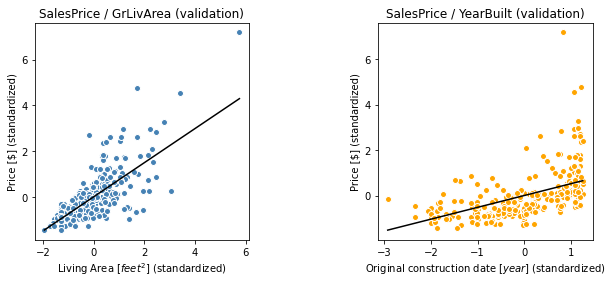

< Metrics (validation data) >
MSE : 0.356
R^2 : 0.683

=== Support Vector Regression ===

< train data >


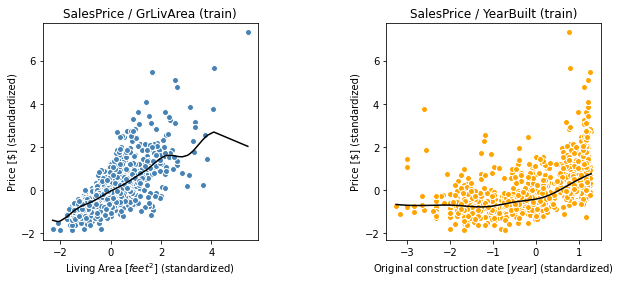

< validation data >


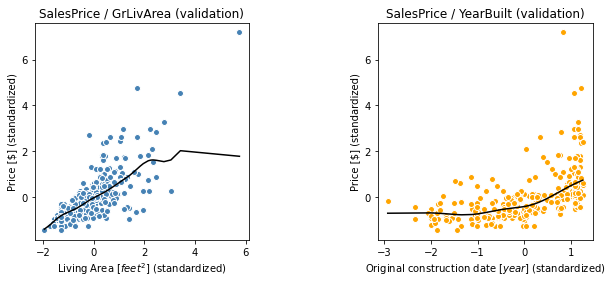

< Metrics (validation data) >
MSE : 0.350
R^2 : 0.689

=== Decision Tree Regression ===

< train data >


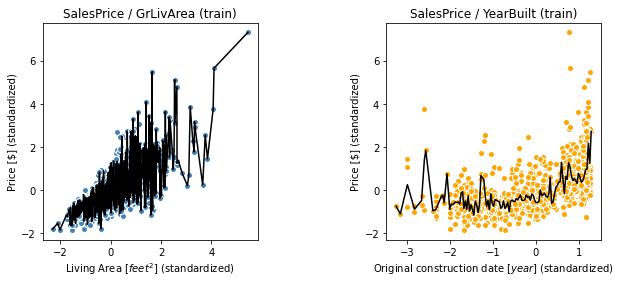

< validation data >


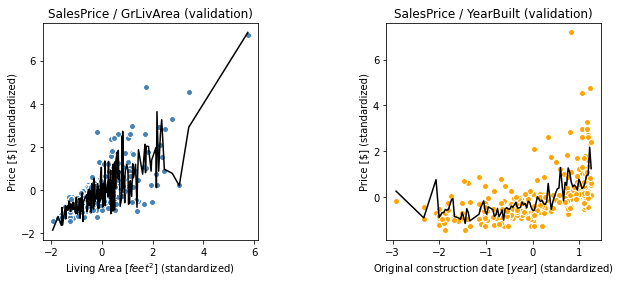

< Metrics (validation data) >
MSE : 0.440
R^2 : 0.609


In [37]:
# 外れ値除去後のデータで再度学習
# 線形回帰
lr = LinearRegression()
lr_1 = copy.deepcopy(lr)
lr_2 = copy.deepcopy(lr)

# SVM
svm = SVR()
svm_1 = copy.deepcopy(svm)
svm_2 = copy.deepcopy(svm)

# 決定木
tree = DecisionTreeRegressor()
tree_1 = copy.deepcopy(tree)
tree_2 = copy.deepcopy(tree)

# 各モデル単体で実行
names = ['LinearRegression', 'Support Vector Regression', 'Decision Tree Regression']
models = np.array([[lr, svm, tree], [lr_1, svm_1, tree_1], [lr_2, svm_2, tree_2]])
execute_regression(names=names, 
                   models=models, 
                   X_train=X_train_del, y_train=y_train_del, 
                   X_val=X_val_del, y_val=y_val_del)


=== Blending (LR:1/3 + SVR:1/3 + Tree:1/3) ===

< train data >


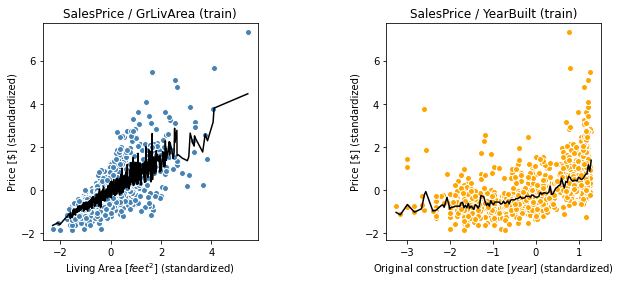

< validation data >


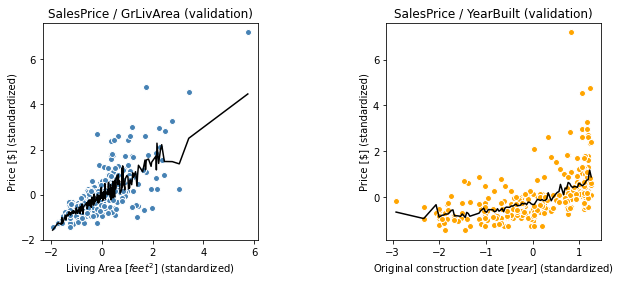

< Metrics (validation data) >
MSE : 0.298
R^2 : 0.735


In [38]:
# 上記の3つをブレンド
lr = LinearRegression()
svm = SVR()
tree = DecisionTreeRegressor()

models = [lr, svm, tree]
# 平均
W = np.array([1/3, 1/3, 1/3])
blend = Blending_Regression(models, W)
blend_1 = copy.deepcopy(blend)
blend_2 = copy.deepcopy(blend)

names = ['Blending (LR:1/3 + SVR:1/3 + Tree:1/3)']
models = np.array([[blend], [blend_1], [blend_2]])
execute_regression(names=names, 
                   models=models, 
                   X_train=X_train_del, y_train=y_train_del, 
                   X_val=X_val_del, y_val=y_val_del)

- Blending（3つの平均）により、どの単体モデルよりも$MSE$が小さくなっている（例①）
（LR : 0.356, SVR : 0.350, Tree : 0.440）

### 2. ハイパーパラメーター  
データは目的・説明変数ともに標準化し、外れ値を除去したものを使用。  
ハーパーパラメータを調整したモデルで学習・推定。


=== LinearRegression ===

< train data >


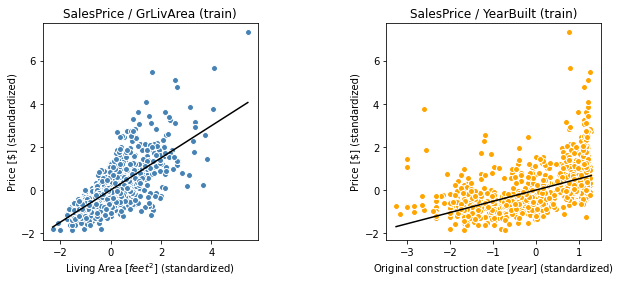

< validation data >


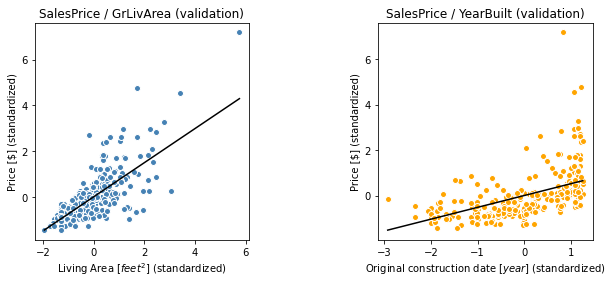

< Metrics (validation data) >
MSE : 0.356
R^2 : 0.683

=== Support Vector Regression(C=10) ===

< train data >


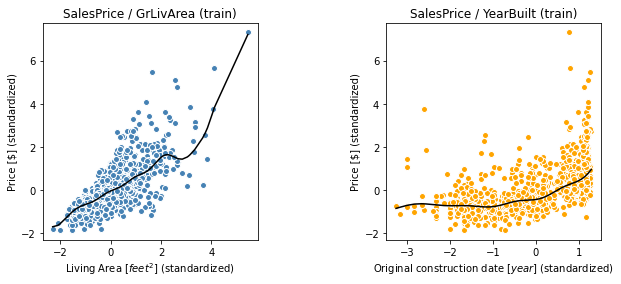

< validation data >


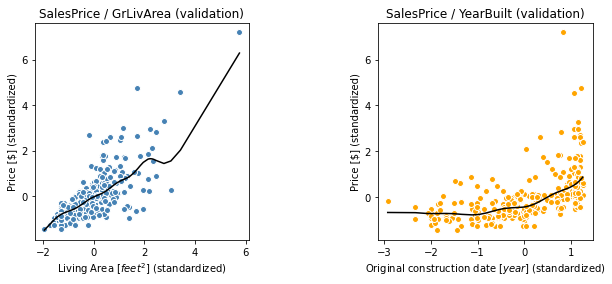

< Metrics (validation data) >
MSE : 0.251
R^2 : 0.777

=== Decision Tree Regression(max_depth=6) ===

< train data >


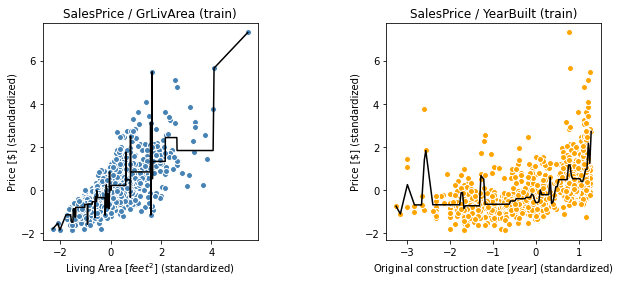

< validation data >


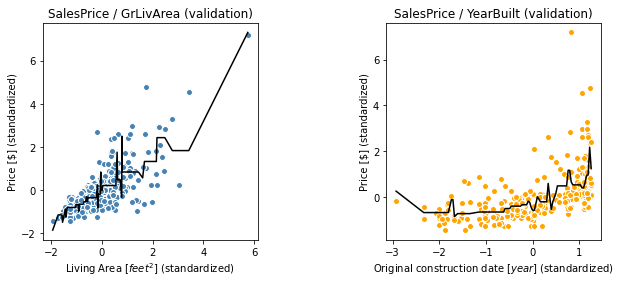

< Metrics (validation data) >
MSE : 0.249
R^2 : 0.779


In [39]:
# パラメーター調整・外れ値除去のデータで学習

# 線形回帰
lr = LinearRegression()
lr_1 = copy.deepcopy(lr)
lr_2 = copy.deepcopy(lr)

# SVM
svm = SVR(C=10)
svm_1 = copy.deepcopy(svm)
svm_2 = copy.deepcopy(svm)

# 決定木
tree = DecisionTreeRegressor(max_depth=6)
tree_1 = copy.deepcopy(tree)
tree_2 = copy.deepcopy(tree)

# 各モデル単体で実行
names = ['LinearRegression', 'Support Vector Regression(C=10)', 'Decision Tree Regression(max_depth=6)']
models = np.array([[lr, svm, tree], [lr_1, svm_1, tree_1], [lr_2, svm_2, tree_2]])
execute_regression(names=names, 
                   models=models, 
                   X_train=X_train_del, y_train=y_train_del, 
                   X_val=X_val_del, y_val=y_val_del)


=== Blending (LR:1/3 + SVR:1/3 + Tree:1/3) ===

< train data >


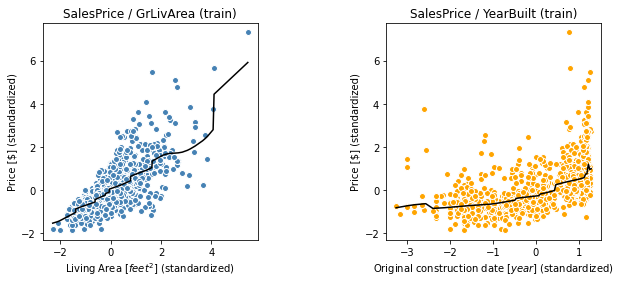

< validation data >


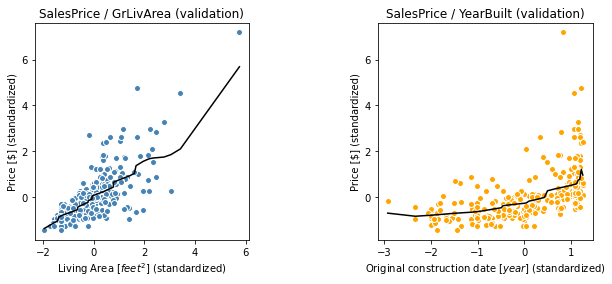

< Metrics (validation data) >
MSE : 0.294
R^2 : 0.739


In [40]:
# 上記の3つをブレンド
lr = LinearRegression()
svm = SVR(C=10)
tree = DecisionTreeRegressor(max_depth=3)

models = [lr, svm, tree]
# 平均
W = np.array([1/3, 1/3, 1/3])
blend = Blending_Regression(models, W)
blend_1 = copy.deepcopy(blend)
blend_2 = copy.deepcopy(blend)

names = ['Blending (LR:1/3 + SVR:1/3 + Tree:1/3)']
models = np.array([[blend], [blend_1], [blend_2]])
execute_regression(names=names, 
                   models=models, 
                   X_train=X_train_del, y_train=y_train_del, 
                   X_val=X_val_del, y_val=y_val_del)

- SVRや決定木の単体に及ばないが、線形回帰単体よりMSEは小さい（例②）（LR : 0.356, Blend : 0.294）
- 決定木の仮説にみられる急激な変動も均されている

### 3. 前処理  
説明変数は標準化、目的変数は対数化し、外れ値を除去したものを使用。  
ハーパーパラメータを調整したモデルで学習・推定。

In [41]:
# データ取得
X = df_house.iloc[:, :-1].values
y = df_house.iloc[:, -1].values

# 目的変数のみ対数化する
log_y = np.log(y)

# 分割
X_train, X_val, log_y_train, log_y_val = train_test_split(
    X, log_y, random_state=0, train_size=0.8)

# 説明変数を標準化する
sc_x = StandardScaler()
sc_x.fit(X_train)
X_train_std = sc_x.transform(X_train)
X_val_std = sc_x.transform(X_val)

# 外れ値と思われるサンプルを削除
X_train_del = np.delete(X_train_std, np.where(X_train_std[:, 0]>6)[0], axis=0)
log_y_train_del = np.delete(log_y_train, np.where(X_train_std[:, 0]>6)[0], axis=0)
X_val_del = np.delete(X_val_std, np.where(X_val_std[:, 0]>7)[0], axis=0)
log_y_val_del = np.delete(log_y_val, np.where(X_val_std[:, 0]>7)[0], axis=0)

In [42]:
# 可視化関数を修正
def execute_regression(names, models, X_train, y_train, X_val, y_val):
    
    # 可視化のため変数毎に分割
    X1_train = X_train[:, 0][:, np.newaxis]
    X2_train = X_train[:, 1][:, np.newaxis]
    
    for i in range(models.shape[1]):
        print("\n=== {} ===\n".format(names[i]))

        # 可視化のため変数毎に学習
        models[1, i].fit(X1_train, y_train)
        models[2, i].fit(X2_train, y_train)

        # 訓練データで可視化
        regression_visualize(X_train, y_train, 
                             model_name='train data', 
                             models=[models[1, i], models[2, i]], 
                             titles=['SalesPrice / GrLivArea (train)', 'SalesPrice / YearBuilt (train)'],
                             colors=['steelblue', 'orange'],
                             xlabels=['Living Area [$feet^2$] (standardized)', 'Original construction date [$year$] (standardized)'],
                             ylabel='log (Price [$]) (logarithm)')
        
        # 検証データで可視化
        regression_visualize(X_val, y_val, 
                             model_name='validation data', 
                             models=[models[1, i], models[2, i]], 
                             titles=['SalesPrice / GrLivArea (validation)', 'SalesPrice / YearBuilt (validation)'],
                             colors=['steelblue', 'orange'],
                             xlabels=['Living Area [$feet^2$] (standardized)', 'Original construction date [$year$] (standardized)'],
                             ylabel='log (Price [$]) (logarithm)')
        
        # 評価(平均二乗誤差、決定係数)
        print("< Metrics (validation data) >")
        models[0, i].fit(X_train, y_train)
        y_val_pred = models[0, i].predict(X_val)
        MSE = mean_squared_error(y_val, y_val_pred)
        print('MSE : {:.3f}'.format(MSE))
        R2 = r2_score(y_val, y_val_pred)
        print('R^2 : {:.3f}'.format(R2))


=== LinearRegression ===

< train data >


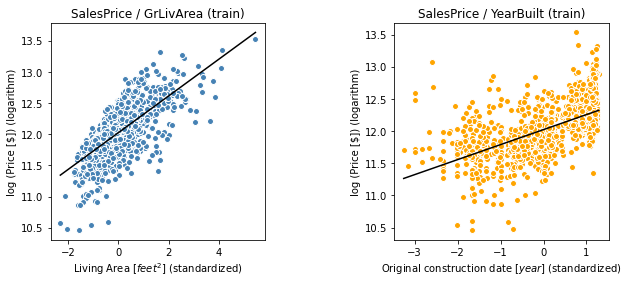

< validation data >


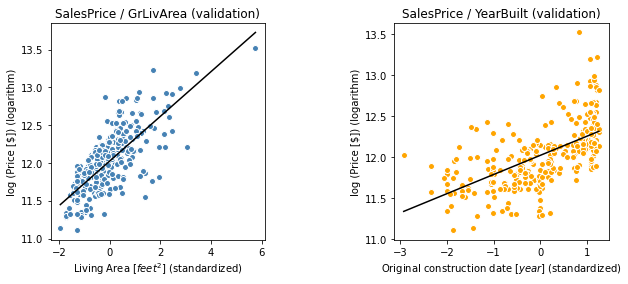

< Metrics (validation data) >
MSE : 0.040
R^2 : 0.738

=== Support Vector Regression (C=1) ===

< train data >


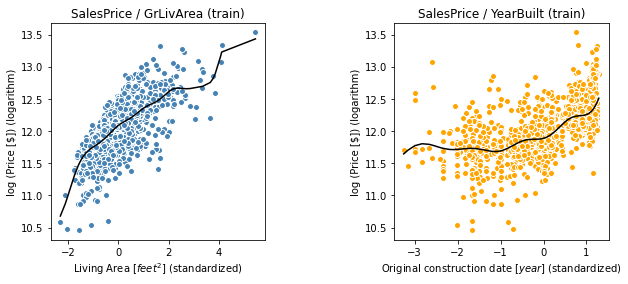

< validation data >


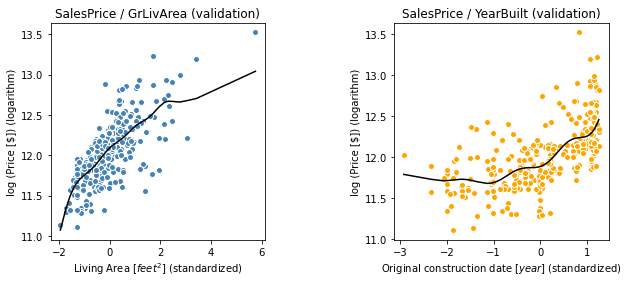

< Metrics (validation data) >
MSE : 0.035
R^2 : 0.767

=== Decision Tree Regression(max_depth=5) ===

< train data >


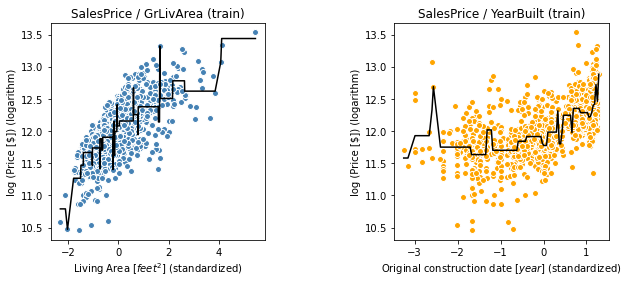

< validation data >


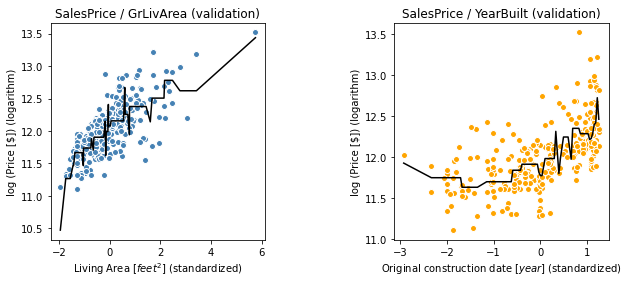

< Metrics (validation data) >
MSE : 0.037
R^2 : 0.754


In [43]:
# 目的変数対数化データで学習

# 線形回帰
lr = LinearRegression()
lr_1 = copy.deepcopy(lr)
lr_2 = copy.deepcopy(lr)

# SVM
svm = SVR(C=10)
svm_1 = copy.deepcopy(svm)
svm_2 = copy.deepcopy(svm)

# 決定木
tree = DecisionTreeRegressor(max_depth=5)
tree_1 = copy.deepcopy(tree)
tree_2 = copy.deepcopy(tree)

# 各モデル単体で実行
names = ['LinearRegression', 'Support Vector Regression (C=1)', 'Decision Tree Regression(max_depth=5)']
models = np.array([[lr, svm, tree], [lr_1, svm_1, tree_1], [lr_2, svm_2, tree_2]])
execute_regression(names=names, 
                   models=models, 
                   X_train=X_train_del, y_train=log_y_train_del, 
                   X_val=X_val_del, y_val=log_y_val_del)


=== Blending (LR:1/3 + SVR:1/3 + Tree:1/3) ===

< train data >


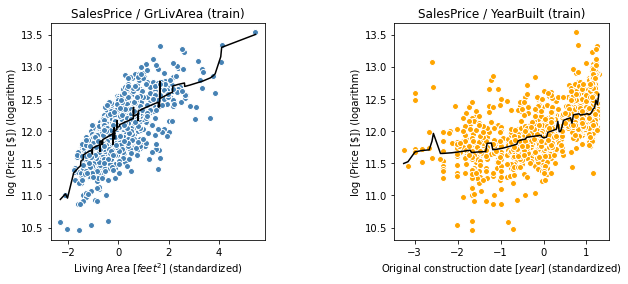

< validation data >


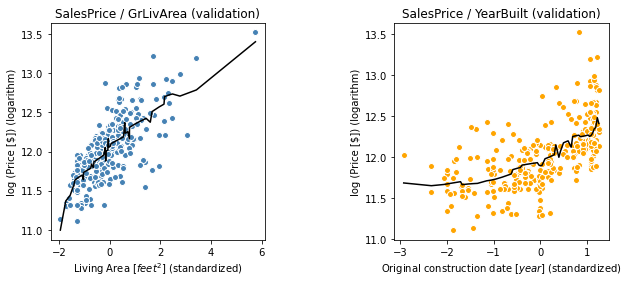

< Metrics (validation data) >
MSE : 0.034
R^2 : 0.773


In [44]:
# 上記の3つをブレンド
lr = LinearRegression()
svm = SVR(C=10)
tree = DecisionTreeRegressor(max_depth=5)

models = [lr, svm, tree]
# 平均
W = np.array([1/3, 1/3, 1/3])
blend = Blending_Regression(models, W)
blend_1 = copy.deepcopy(blend)
blend_2 = copy.deepcopy(blend)

names = ['Blending (LR:1/3 + SVR:1/3 + Tree:1/3)']
models = np.array([[blend], [blend_1], [blend_2]])
execute_regression(names=names, 
                   models=models, 
                   X_train=X_train_del, y_train=log_y_train_del, 
                   X_val=X_val_del, y_val=log_y_val_del)

- 目的変数を対数化しため$MSE$の尺度は大きく変化したが、決定係数の尺度は変わらない
- 対数化により、線形回帰単体は予測性能が向上している（$R^2$=0.683→0.738）
- Blending（平均）では、同条件の全ての単体モデルよりも$MSE$が小さくなっている（例③）（LR : 0.040, SVR : 0.035, Tree : 0.037）

  
  
  
- 3つの平均ではなく、任意の重みでブレンドしてみる↓


=== Blending (LR:2/10 + SVR:5/10 + Tree:3/10) ===

< train data >


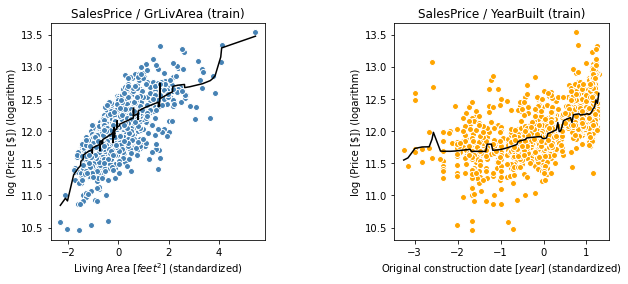

< validation data >


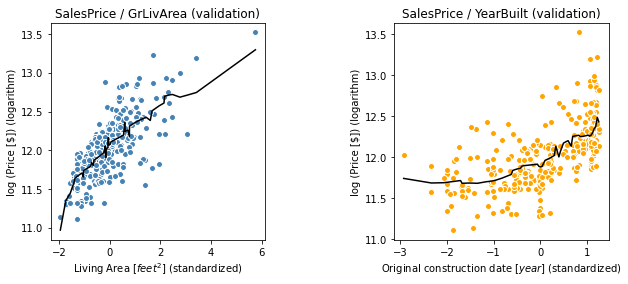

< Metrics (validation data) >
MSE : 0.034
R^2 : 0.776


In [45]:
# 上記の3つをブレンド
lr = LinearRegression()
svm = SVR(C=10)
tree = DecisionTreeRegressor(max_depth=5)

models = [lr, svm, tree]
# 任意の重みで加重平均をとる
W = np.array([0.2, 0.5, 0.3])
blend = Blending_Regression(models, W)
blend_1 = copy.deepcopy(blend)
blend_2 = copy.deepcopy(blend)

names = ['Blending (LR:2/10 + SVR:5/10 + Tree:3/10)']
models = np.array([[blend], [blend_1], [blend_2]])
execute_regression(names=names, 
                   models=models, 
                   X_train=X_train_del, y_train=log_y_train_del, 
                   X_val=X_val_del, y_val=log_y_val_del)

- 重み付き平均とすることで、性能が僅かに上がったようだ。（$R^2$ : 0.773→0.776）
- scipyのoptimizeメソッドを用いて最適な重みを求める方法もあるらしい

### 【問題2】バギングのスクラッチ実装  
バギング をスクラッチ実装し、単一モデルより精度があがる例を 最低1つ 示してください。  

＜バギングとは＞  
バギングは入力データの選び方を多様化する方法です。学習データから重複を許した上でランダムに抜き出すことで、N種類のサブセット（ ブートストラップサンプル ）を作り出します。それらによってモデルをN個学習し、推定結果の平均をとります。ブレンディングと異なり、それぞれの重み付けを変えることはありません。  

scikit-learnのtrain_test_splitを、shuffleパラメータをTrueにして使うことで、ランダムにデータを分割することができます。これによりブートストラップサンプルが手に入ります。  

推定結果の平均をとる部分はブースティングと同様の実装になります。

In [46]:
# Bagging Classの実装

class Bagging_Regression():
    """
    回帰問題バギングのスクラッチ実装

    Parameters
    ----------
    model : object
      バギングするモデルのオブジェクト
    n_subset : int
      サブセット数
    train_size : float
      検証データの割合
    """
    
    def __init__(self, model, n_subset, train_size):
        # ハイパーパラメータを属性として記録
        # Baggingを行うモデルオブジェクト
        self.model = model
        # 作成するサブセットの数
        self.n_subset = n_subset
        self.train_size = train_size
        self.models = []
        
    def fit(self, X, y):
        """
   　　 受け取ったデータでバギング学習を行う

    　　Parameters
    　　----------
    　　X : 次の形のndarray, shape (n_samples, n_features)
      　　訓練データの説明変数
        y : 次の形のndarray, shape (n_samples, )
      　　訓練データの目的変数
      　"""
        # サブセット種のループ
        for i in range(self.n_subset):
            # 訓練データをランダムに分割
            X_train, X_re, y_train, y_re = train_test_split(X, y, 
                                               train_size=self.train_size, 
                                               shuffle=True)
            # 学習モデルのクラスオブジェクトを複製
            model_i = copy.deepcopy(self.model)
            # 分割したデータで学習後、リストに格納
            model_i.fit(X_train, y_train)
            self.models.append(model_i)
        return self
     
    def predict(self, X):
        """
   　　 バギング学習モデルで推定を行う

    　　Parameters
    　　----------
    　　X : 次の形のndarray, shape (n_samples, n_features)
      　　予測するデータの説明変数
    　　
      　Returns
        -------
        y_pred : 次の形のndarray, shape (n_samples, 1)
          バギング後のモデルによる推定結果
      　"""
        
        # 予測行列を初期値0で作成
        predicts = np.zeros([X.shape[0], self.n_subset])
        # 該当モデルで推定、予測行列を更新
        for i in range(self.n_subset):
            predicts[:, i] = self.models[i].predict(X)
        # 行方向に平均をとり出力
        return np.mean(predicts, axis=1)

### ＜方針＞  
決定係数から、データは説明変数を標準化・目的変数を対数化し、外れ値を除去したものを用いる。  
学習モデルは問題 1 でハイパーパラメーター調整した線形回帰、SVR、決定木を用いる。  
subsetの数は10としてみる。


=== Bagging (Linear Regression), n_subset=10 ===

< train data >


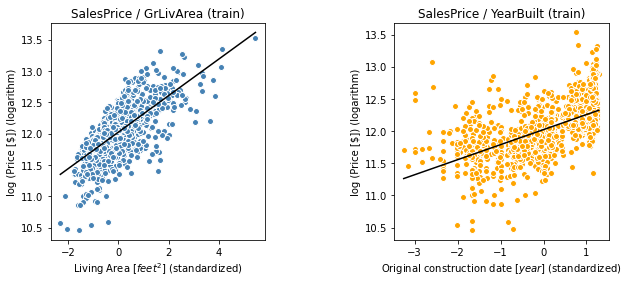

< validation data >


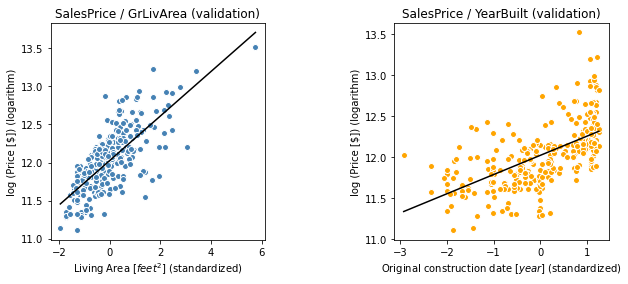

< Metrics (validation data) >
MSE : 0.040
R^2 : 0.738

=== Bagging (Support Vector Regression, C=10), n_subset=10 ===

< train data >


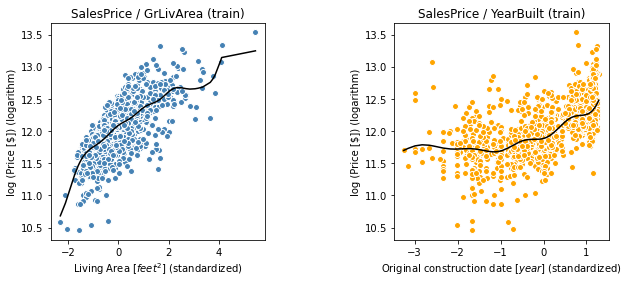

< validation data >


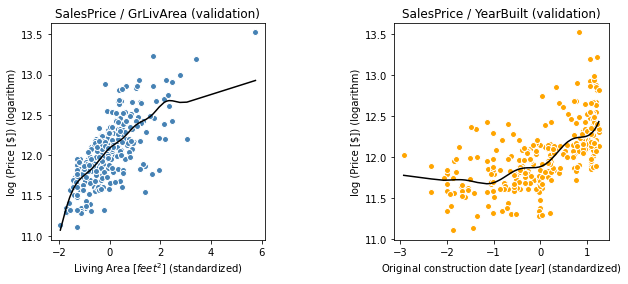

< Metrics (validation data) >
MSE : 0.035
R^2 : 0.769

=== Bagging (Decision Tree Regression, max_depth=5), n_subset=10 ===

< train data >


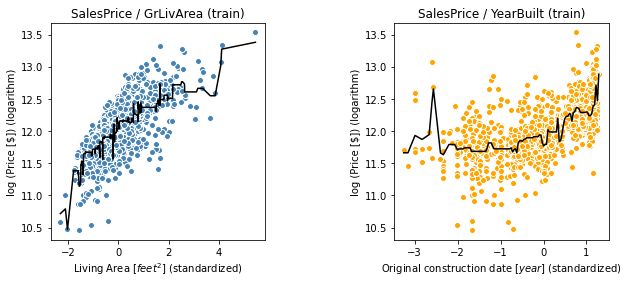

< validation data >


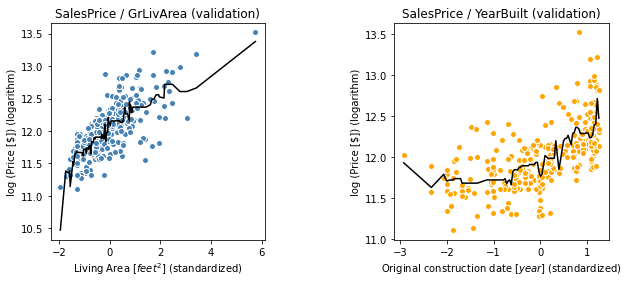

< Metrics (validation data) >
MSE : 0.033
R^2 : 0.781


In [47]:
# Bagging

# 線形回帰
lr = LinearRegression()
lr_bag = Bagging_Regression(lr, n_subset=10, train_size=0.8)
lr_bag_1 = copy.deepcopy(lr_bag)
lr_bag_2 = copy.deepcopy(lr_bag)

# SVM
svm = SVR(C=10)
svm_bag = Bagging_Regression(svm, n_subset=10, train_size=0.8)
svm_bag_1 = copy.deepcopy(svm_bag)
svm_bag_2 = copy.deepcopy(svm_bag)

# 決定木
tree = DecisionTreeRegressor(max_depth=5)
tree_bag = Bagging_Regression(tree, n_subset=10, train_size=0.8)
tree_bag_1 = copy.deepcopy(tree_bag)
tree_bag_2 = copy.deepcopy(tree_bag)

names = ['Bagging (Linear Regression), n_subset=10', 
         'Bagging (Support Vector Regression, C=10), n_subset=10', 
         'Bagging (Decision Tree Regression, max_depth=5), n_subset=10']
models = np.array([[lr_bag, svm_bag, tree_bag], 
                   [lr_bag_1, svm_bag_1, tree_bag_1], 
                   [lr_bag_2, svm_bag_2, tree_bag_2]])

execute_regression(names=names, 
                   models=models, 
                   X_train=X_train_del, y_train=log_y_train_del, 
                   X_val=X_val_del, y_val=log_y_val_del)

- 線形回帰、SVRでは評価指標にほとんど変化がないが、決定木は向上（$R^2$ : 0.754 → 0.781）している（例①）
- ノンパラメトリックモデルの決定木は学習データを過学習しやすいため、Baggingで多種類の木の予測を組み合わせたことにより汎化性能が向上したものと思われる。

### 【問題3】スタッキングのスクラッチ実装  
**スタッキング** をスクラッチ実装し、単一モデルより精度があがる例を **最低1つ** 示してください。

＜スタッキングとは＞  
スタッキングの手順は以下の通りです。最低限ステージ0とステージ1があればスタッキングは成立するため、それを実装してください。まずは $K_0=3, M_0=2$ 程度にします。


《学習時》  

（ステージ $0$）  
- 学習データを $K_0$ 個に分割する。  
- 分割した内の $(K_0 - 1)$ 個をまとめて学習用データ、残り $1$ 個を推定用データとする組み合わせが $K_0$ 個作れる。  
- あるモデルのインスタンスを $K_0$ 個用意し、異なる学習用データを使い学習する。  
- それぞれの学習済みモデルに対して、使っていない残り $1$ 個の推定用データを入力し、推定値を得る。（これをブレンドデータと呼ぶ）  
- さらに、異なるモデルのインスタンスも $K_0$ 個用意し、同様のことを行う。モデルが $M_0$ 個あれば、 $M_0$ 個のブレンドデータが得られる。  

（ステージ $n$）   
- ステージ $n-1$ のブレンドデータを$M_{n-1}$ 次元の特徴量を持つ学習用データと考え、 $K_n$ 個に分割する。以下同様である。  

（ステージ $N$ ）＊最後のステージ  
- ステージ $N-1$ の $M_{N-1}$ 個のブレンドデータを$M_{N-1}$ 次元の特徴量の入力として、1種類のモデルの学習を行う。これが最終的な推定を行うモデルとなる。  


《推定時》  

（ステージ $0$ ）  
- テストデータを $K_0×M_0$ 個の学習済みモデルに入力し、$K_0×M_0$ 個の推定値を得る。  これを $K_0$ の軸で平均値を求め $M_0$ 次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）

（ステージ $n$ ）  
- ステージ $n-1$ で得たブレンドテストを $K_n×M_n$ 個の学習済みモデルに入力し、$K_n×M_n$ 個の推定値を得る。これを $K_n$ の軸で平均値を求め $M_0$ 次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）  

（ステージ $N$ ）＊最後のステージ  
- ステージ $N-1$ で得たブレンドテストを学習済みモデルに入力し、推定値を得る。

### ＜方針＞  
実装にあたっては多ステージにも対応するようにし、各stage別の学習サブモデルを2次元リストで渡す。
  
Stackingの適応にあたっては、ハイパーパラメーター調整済みの線形回帰, SVR, 決定木の3種類で、サブ / メインモデルの組み合わせを試す。データは目的・説明変数ともに標準化し、外れ値を除去したものを用いる。

In [48]:
# Stacking Classの実装

class Stacking_Regression():
    """
    回帰問題スタッキングのスクラッチ実装

    Parameters
    ----------
    submodels : list
      サブモデルのオブジェクト2次元リスト
    model : object
      メインモデルのオブジェクト
    n_split : int
      データの分割数
    random_state : int
      乱数シード

    Attributes
    ----------
    self.fitted_submodels : list
      学習済みサブモデルのオブジェクト3次元リスト
    """
    
    def __init__(self, submodels, mainmodel, n_split, max_stage=1, random_state=None):
        # ハイパーパラメータを属性として記録
        # 該当するstage・種類での2次元サブモデルリスト
        self.submodels = submodels
        # メインモデルオブジェクト
        self.mainmodel = mainmodel
        # 各stageでのデータ分割数
        self.n_split = n_split
        # ステージ2以上を設定できるようにする
        self.max_stage = max_stage
        # 再現性のため、乱数シードを渡す
        self.random_state = random_state
        # 学習済みサブモデルを保持する3次元リスト
        self.fitted_submodels = []
    
    def fit(self, X, y):
        """
   　　 メインモデルによる最終学習

    　　Parameters
    　　----------
    　　X : 次の形のndarray, shape (n_samples, n_features)
      　　訓練データの説明変数
        y : 次の形のndarray, shape (n_samples, )
      　　訓練データの目的変数
    　　
        """
        # stage0からサブモデルによる再帰的学習を開始
        X_main = self._sub_fit(X, y, stage=0, max_stage=self.max_stage)
        # サブモデルからの最終説明変数をメインモデルで学習
        self.mainmodel.fit(X_main, y)
        
        return self
        
    
    def _sub_fit(self, X, y, stage, max_stage):
        """
   　　 サブモデルによる再帰的学習

    　　Parameters
    　　----------
    　　X : 次の形のndarray, shape (n_samples, n_features)
      　　訓練データの説明変数
        y : 次の形のndarray, shape (n_samples, )
      　　訓練データの目的変数
    　　
        """
        
        # 乱数シード固定
        np.random.seed(self.random_state)
        # サンプルのインデックスをシャッフル
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        # 分割数より検証データ数を算出しておく
        n_val = int(X.shape[0]/self.n_split)
        # 出力する説明変数を初期値0で作成
        X_main = np.zeros([X.shape[0], len(self.submodels[stage])])
        
        # 各ステージでの学習済みサブモデル格納2次元リスト
        submodels_2 = []
        # サブモデルの種類ループ
        
        for i in range(len(self.submodels[stage])):
            # モデルの種類ごとの出力結果を初期値0で作成
            submodel_preds = np.zeros(X.shape[0])
            # モデル種別の学習済みサブモデル格納1次元リスト
            submodels_1 = []
            # 分割によるループ
            for j in range(self.n_split):
                # 検証/訓練データのインデックス取得
                idx_val = np.arange(n_val*j, n_val*(j+1))
                idx_train = np.array(list(set(indices) - set(idx_val)))
                X_val = X[idx_val]
                X_train = X[idx_train]
                y_train = y[idx_train]
                # 該当stage・種類のモデルオブジェクトの複製を作り学習
                submodel = copy.deepcopy(self.submodels[stage][i])
                submodel.fit(X_train, y_train)
                # 種類別予測結果の該当インデックスを推定結果で更新
                submodel_preds[idx_val] = submodel.predict(X_val)
                # 学習済みモデルを後に呼び出せるよう、リストに格納
                submodels_1.append(submodel)
            # メインモデルへの説明変数の該当する列を更新
            X_main[:, i] = submodel_preds
            # リストをリストに格納し、2次元リストで学習済みサブモデルを保持
            submodels_2.append(submodels_1)
        # 2次元リストをリストに格納し、3次元リストで学習済みサブモデルを保持
        self.fitted_submodels.append(submodels_2)
        
        # 最終の1stage前なら、サブモデルからの説明変数を出力
        if stage == max_stage - 1:
            output = X_main
        # 上記以外では、再帰的に学習を継続
        else:
            output = self._sub_fit(X_main, y, stage+1, max_stage)
        
        return output
    

    def predict(self, X):
        """
        メインモデルによる最終推定

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
        　予測するデータの説明変数
        Returns
        -------
        y_pred : 次の形のndarray, shape (n_samples, 1)
        　スタッキング後のメインモデルによる推定結果
        """
        # stage0からサブモデルによる再帰的推定を開始
        sub_preds = self._sub_predict(X, stage=0, max_stage=self.max_stage)

        # サブモデル推定結果からメインモデルが推定し結果を出力
        return self.mainmodel.predict(sub_preds)

    
    def _sub_predict(self, X, stage, max_stage):
        """
        サブモデルによる再帰的推定

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
        　予測するデータの説明変数
        Returns
        -------
        y_pred : 次の形のndarray, shape (n_samples, 1)
        　スタッキング後のメインモデルによる推定結果
        """
        # サブモデルの推定結果を初期値0で作成
        sub_preds = np.zeros([X.shape[0], len(self.submodels[stage])])

        for i in range(len(self.submodels[stage])):
            # モデルの種類ごとの予測結果を初期値0で作成
            submodel_preds = np.zeros([X.shape[0], self.n_split])
            for j in range(self.n_split):
                # 学習済みモデル3次元リストから、該当stageの該当モデル呼び出し
                submodel = self.fitted_submodels[stage][i][j]
                # 種類別予測行列の該当列を更新
                submodel_preds[:, j] = submodel.predict(X)  
            
            # 予測行列を行方向に平均し、サブモデル推定結果の該当列を更新
            sub_preds[:, i] = np.mean(submodel_preds, axis=1)
        
        # 最終の1stage前なら、サブモデルからの予測結果を出力
        if stage == max_stage-1:
            output = sub_preds
        # 上記以外では、再帰的に予測を継続
        else:
            output = self._sub_predict(sub_preds, stage+1, max_stage)
        
        return output


=== Stacking (sub : SVM(C=10), Tree(max_depth=5) / main : LR) ===

< train data >


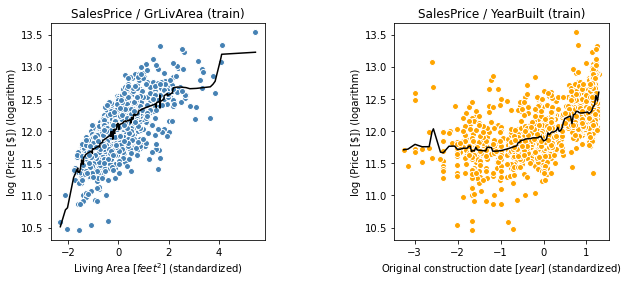

< validation data >


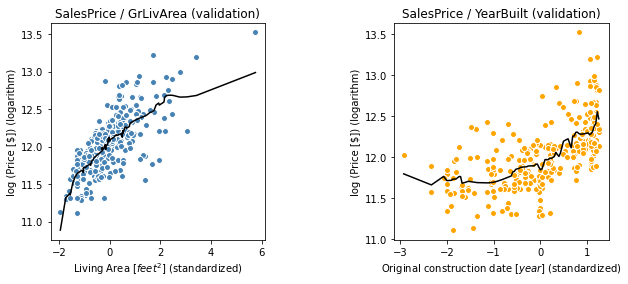

< Metrics (validation data) >
MSE : 0.033
R^2 : 0.781
(n_split=3, max_stage=1)


In [49]:
# Stacking 1 (サブ：SVR, 決定木　メイン：線形回帰)
lr = LinearRegression()
svm = SVR(C=10)
tree = DecisionTreeRegressor(max_depth=5)
# stage 0 でSVRと決定木  
lr_stk = Stacking_Regression(submodels=[[svm, tree]], 
                             mainmodel=lr, 
                             n_split=3,
                             max_stage=1,
                             random_state=1)
lr_stk_1 = copy.deepcopy(lr_stk)
lr_stk_2 = copy.deepcopy(lr_stk)

names = ['Stacking (sub : SVM(C=10), Tree(max_depth=5) / main : LR)']
models = np.array([[lr_stk], [lr_stk_1], [lr_stk_2]])

execute_regression(names=names, 
                   models=models, 
                   X_train=X_train_del, y_train=log_y_train_del, 
                   X_val=X_val_del, y_val=log_y_val_del)
print('(n_split=3, max_stage=1)')

- 単体の線形回帰（$R^2$=0.738）はもちろん、平均のBlending（$R^2$=0.773）も上回っている（例①）


=== Stacking (sub : LR, Tree(max_depth=5) / main : SVR(C=10)) ===

< train data >


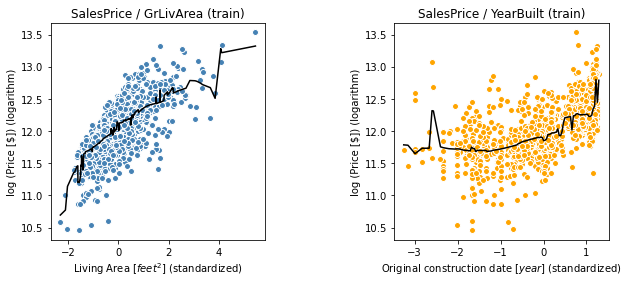

< validation data >


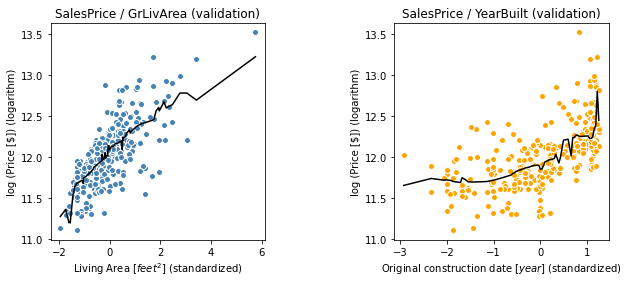

< Metrics (validation data) >
MSE : 0.037
R^2 : 0.759
(n_split=3, max_stage=1)


In [50]:
# Stacking 2(サブ：線形回帰, 決定木　メイン：SVR)
lr = LinearRegression()
svm = SVR(C=10)
tree = DecisionTreeRegressor(max_depth=5)
# stage 0 で線形回帰と決定木  
svm_stk = Stacking_Regression(submodels=[[lr, tree]], 
                              mainmodel=svm, 
                              n_split=3,
                              max_stage=1,
                              random_state=1)
svm_stk_1 = copy.deepcopy(svm_stk)
svm_stk_2 = copy.deepcopy(svm_stk)

names = ['Stacking (sub : LR, Tree(max_depth=5) / main : SVR(C=10))']
models = np.array([[svm_stk], [svm_stk_1], [svm_stk_2]])

execute_regression(names=names, 
                   models=models, 
                   X_train=X_train_del, y_train=log_y_train_del, 
                   X_val=X_val_del, y_val=log_y_val_del)
print('(n_split=3, max_stage=1)')


=== Stacking (sub : LR, SVR(C=10) / main : Tree(max_depth=5)) ===

< train data >


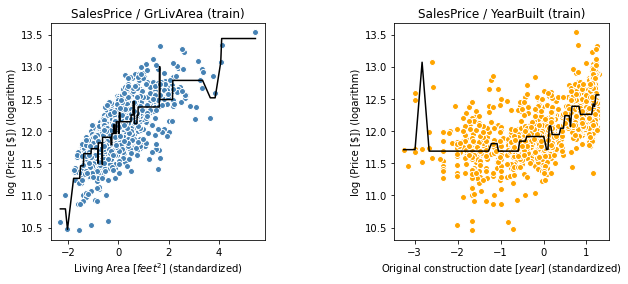

< validation data >


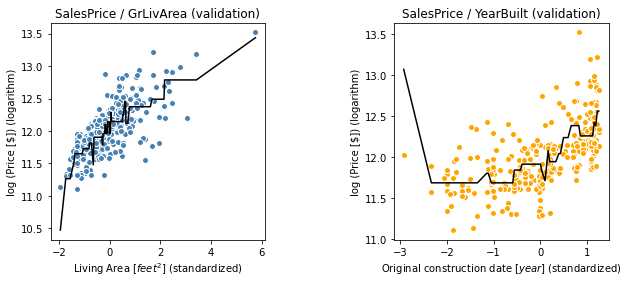

< Metrics (validation data) >
MSE : 0.041
R^2 : 0.732
(n_split=3, max_stage=1)


In [51]:
# Stacking 3(サブ：線形回帰, SVR　メイン：決定木)
lr = LinearRegression()
svm = SVR(C=10)
tree = DecisionTreeRegressor(max_depth=5)
# stage 0 で線形回帰とSVR  
tree_stk = Stacking_Regression(submodels=[[lr, svm]], 
                              mainmodel=tree, 
                              n_split=3,
                              max_stage=1,
                              random_state=1)
tree_stk_1 = copy.deepcopy(tree_stk)
tree_stk_2 = copy.deepcopy(tree_stk)

names = ['Stacking (sub : LR, SVR(C=10) / main : Tree(max_depth=5))']
models = np.array([[tree_stk], [tree_stk_1], [tree_stk_2]])

execute_regression(names=names, 
                   models=models, 
                   X_train=X_train_del, y_train=log_y_train_del, 
                   X_val=X_val_del, y_val=log_y_val_del)
print('(n_split=3, max_stage=1)')

- メインモデルをSVRもしくは決定木とし、上記以外をサブモデルにして試したが、いずれも単体モデルのSVRや決定木より性能が下がっている
- Stackingする際には、サブモデルとメインモデルをどう選定するかが重要であるようだ

### 【おまけ】$K_n$, stage を増やす  
- 問題 3 で最も性能の良いサブ：SVM, 決定木 / メイン：線形回帰　の組み合わせで、``n_split``, ``max_stage``を上げてみる。  
- stage 0or1 で 決定木orSVR がサブモデルとして学習し、stage 2 で 線形回帰 が学習する。


=== Stacking (sub0 : Tree(max_depth=5), sub1 : SVM(C=10) / main : LR) ===

< train data >


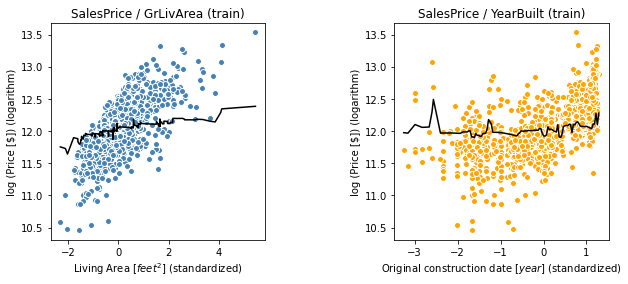

< validation data >


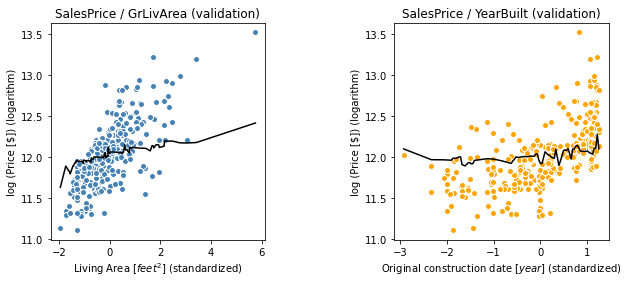

< Metrics (validation data) >
MSE : 0.091
R^2 : 0.404
(n_split=7, max_stage=1 )


In [52]:
# Stacking (サブ：SVR, 決定木　メイン：線形回帰)
lr = LinearRegression()
svm = SVR(C=10)
tree = DecisionTreeRegressor(max_depth=5)
# stage 0 でSVRと決定木  
lr_stk = Stacking_Regression(submodels=[[tree, svm]], 
                             mainmodel=lr, 
                             n_split=5,
                             max_stage=1,
                             random_state=1)
lr_stk_1 = copy.deepcopy(lr_stk)
lr_stk_2 = copy.deepcopy(lr_stk)

names = ['Stacking (sub0 : Tree(max_depth=5), sub1 : SVM(C=10) / main : LR)']
models = np.array([[lr_stk], [lr_stk_1], [lr_stk_2]])

execute_regression(names=names, 
                   models=models, 
                   X_train=X_train_del, y_train=log_y_train_del, 
                   X_val=X_val_del, y_val=log_y_val_del)
print('(n_split=7, max_stage=1 )')

- 単に分割数（$K_n$）を増やすと、むしろ予測性能が悪くなる


=== Stacking (sub0 : Tree(max_depth=5), sub1 : SVM(C=10) / main : LR) ===

< train data >


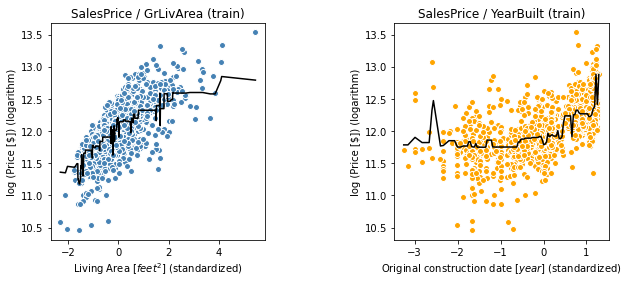

< validation data >


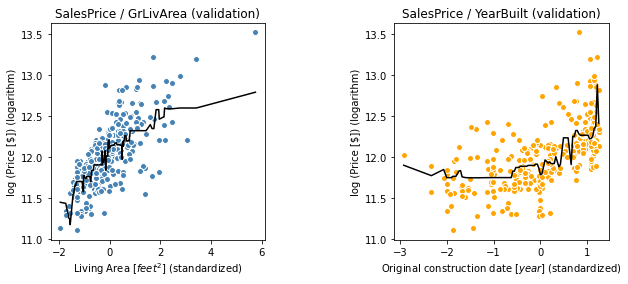

< Metrics (validation data) >
MSE : 0.033
R^2 : 0.786
(n_split=3, max_stage=2 (Tree→SVR))


In [53]:
# Stacking (サブ：SVR, 決定木　メイン：線形回帰)
lr = LinearRegression()
svm = SVR(C=10)
tree = DecisionTreeRegressor(max_depth=5)
# stage 0 で決定木, stage 1 でSVR  
lr_stk = Stacking_Regression(submodels=[[tree], [svm]], 
                             mainmodel=lr, 
                             n_split=3,
                             max_stage=2,
                             random_state=1)
lr_stk_1 = copy.deepcopy(lr_stk)
lr_stk_2 = copy.deepcopy(lr_stk)

names = ['Stacking (sub0 : Tree(max_depth=5), sub1 : SVM(C=10) / main : LR)']
models = np.array([[lr_stk], [lr_stk_1], [lr_stk_2]])

execute_regression(names=names, 
                   models=models, 
                   X_train=X_train_del, y_train=log_y_train_del, 
                   X_val=X_val_del, y_val=log_y_val_del)
print('(n_split=3, max_stage=2 (Tree→SVR))')


=== Stacking (sub0 : SVM(C=10), sub1 : Tree(max_depth=5) / main : LR) ===

< train data >


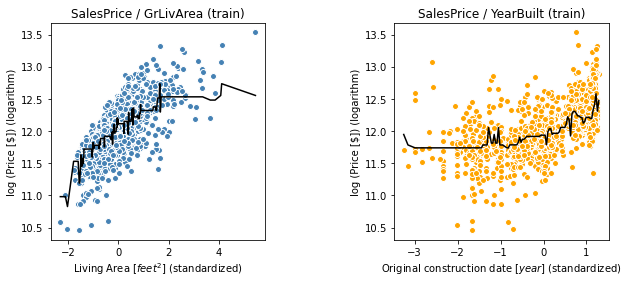

< validation data >


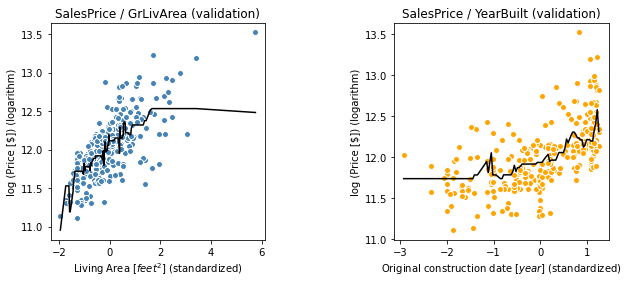

< Metrics (validation data) >
MSE : 0.040
R^2 : 0.737
(n_split=3, max_stage=2 (SVR→Tree))


In [54]:
# Stacking (サブ：SVR, 決定木　メイン：線形回帰)
lr = LinearRegression()
svm = SVR(C=10)
tree = DecisionTreeRegressor(max_depth=5)
# stage 0 でSVR, stage 1 で決定木
lr_stk = Stacking_Regression(submodels=[[svm], [tree]], 
                             mainmodel=lr, 
                             n_split=3,
                             max_stage=2,
                             random_state=1)
lr_stk_1 = copy.deepcopy(lr_stk)
lr_stk_2 = copy.deepcopy(lr_stk)

names = ['Stacking (sub0 : SVM(C=10), sub1 : Tree(max_depth=5) / main : LR)']
models = np.array([[lr_stk], [lr_stk_1], [lr_stk_2]])

execute_regression(names=names, 
                   models=models, 
                   X_train=X_train_del, y_train=log_y_train_del, 
                   X_val=X_val_del, y_val=log_y_val_del)
print('(n_split=3, max_stage=2 (SVR→Tree))')

- stage数を2とし、各stageでの学習サブモデルを1種類にしてみた
- 僅差だが、stage 0 SVR + 決定木（$R^2$ = 0.781）よりも、stage 0 決定木 → stage 1 SVR で線形回帰をメインとして用いる方法（$R^2$ = 0.786）が最も性能が良かった
- stage 0 SVR → stage 1 決定木 で線形回帰メイン（$R^2$ = 0.737）は、やや性能が劣った
- サブモデルの種類に加え、順番も影響するようだ

### ＜考察のまとめ＞
1. Blending  
各モデルの予測性能が低い際には、Blendingによって予測性能の向上が期待できそう。しかし、モデルの組み合わせは必ずしも構成要素単体の予測性能を上回るわけではない。
2. Bagging  
決定木など、過学習になりやすい怠惰学習モデルに対しては、特に有効な手法と思われる。
3. Stacking  
組み合わせ方によっては、単純なBlendingよりも予測性能を向上させることが期待できる。ただし、サブ/メインモデルの選定や各stageで学習するサブモデルの順列によって性能が変化する。線形回帰などBiasが大きくVarianceの小さいモデルをメインモデルにした方が良い印象。

→　結局は王道となる指針はなく、予測対象のデータセットに対して色々な組み合わせを試していくしかないように思われる。